Initial point w0: [-0.39366615 -0.1530163 ]


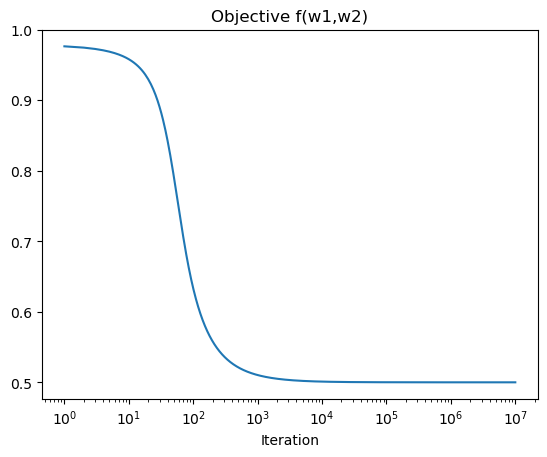

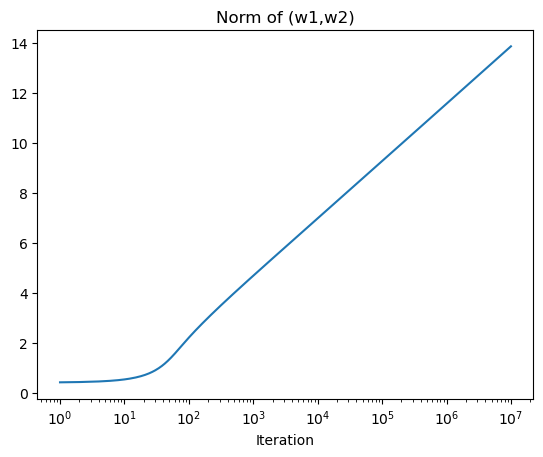

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu" # Force JAX to use only CPU platforms

import numpy as np
import jax
from jax import config
config.update("jax_enable_x64", True) # use float64 everywhere

import jax.numpy as jnp
import jax.nn as jnn
import matplotlib.pyplot as plt

# ----- settings -----
K = 1 * 10**7 # total iterations
alpha = 0.1
beta = 0.0

# single initial point for (w1, w2)
key = jax.random.key(96) # You can change to any other seeds if you like. 
w0 = jax.random.normal(key, (2,), dtype=jnp.float64)
print("Initial point w0:", w0)

# ----- objective f(w1, w2) = (1/2)*[(1 - w2*σ(w1))^2 + (-1 - w2*σ(-w1))^2] -----
def obj(w):
    w1, w2 = w
    s_pos = jnn.sigmoid(w1) # σ(w1)
    s_neg = jnn.sigmoid(-w1) # σ(-w1) = 1 - σ(w1), but we can call sigmoid directly

    term1 = 1.0  - w2 * s_pos # (1 - w2 σ(w1))
    term2 = -1.0 - w2 * s_neg # (-1 - w2 σ(-w1))

    return 0.5 * (term1**2 + term2**2)

# autodiff in float64
value_and_grad = jax.value_and_grad(obj)

@jax.jit
def run(w0):
    def step(w, i):
        val, grad = value_and_grad(w)
        norm = jnp.linalg.norm(w)
        step_size = alpha / jnp.power(i + 1, beta)
        w_next = w - step_size * grad
        return w_next, (val, norm)

    w_final, (vals_hist, norms_hist) = jax.lax.scan(
        step,
        w0,
        jnp.arange(K)
    )
    return vals_hist, norms_hist, w_final

# ----- run and plot -----
vals, norms, w_final = run(w0)

vals  = np.array(vals) 
norms = np.array(norms)
iters = np.arange(1, K + 1, dtype=np.int64)

plt.figure()
plt.plot(iters, vals)
plt.xscale("log")
plt.title("Objective f(w1,w2)")
plt.xlabel("Iteration")

plt.figure()
plt.plot(iters, norms)
plt.xscale("log")
plt.title("Norm of (w1,w2)")
plt.xlabel("Iteration")

plt.show()